In [1]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)



Python:  3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:24:55) 
[Clang 11.1.0 ]
pandas:  1.4.1
numpy:  1.23.3
seaborn:  0.11.2
matplotlib:  3.5.1
sklearn:  1.0.2
Keras:  2.8.0
Tensorflow:  2.8.0


In [5]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [7]:
##filePath = './data/creditcardanomalydetection.csv'
##filePath = './dataset/creditcard.csv'
filePath = '../../../sjkangtfws/datasets/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()


284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [10]:
#simple autoencoder
#logfilename = "simpleautoencoder"

#encoding_dim = 12
#input_dim = x_train.shape[1]

#inputArray = Input(shape=(input_dim,))
#encoded = Dense(encoding_dim, activation='relu')(inputArray)

#decoded = Dense(input_dim, activation='softmax')(encoded)

#autoencoder = Model(inputArray, decoded)
#autoencoder.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense (Dense)               (None, 12)                360       
                                                                 
 dense_1 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


2022-10-26 11:13:28.675811: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-26 11:13:28.676226: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
#sparse autoencoder
#logfilename = "sparseautoencoder"

#encoding_dim = 12
#input_dim = x_train.shape[1]

#inputArray = Input(shape=(input_dim,))
#encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(inputArray)

#decoded = Dense(input_dim, activation='softmax')(encoded)

#autoencoder = Model(inputArray, decoded)
#autoencoder.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_2 (Dense)             (None, 12)                360       
                                                                 
 dense_3 (Dense)             (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [38]:
#deep autoencoder

logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_4 (Dense)             (None, 16)                480       
                                                                 
 dense_5 (Dense)             (None, 8)                 136       
                                                                 
 dense_6 (Dense)             (None, 4)                 36        
                                                                 
 dense_7 (Dense)             (None, 8)                 40        
                                                                 
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 29)                493 

In [39]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [40]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])


Epoch 1/20


2022-10-26 11:50:47.177779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


506/510 [============================>.] - ETA: 0s - loss: 1.4554 - mae: 0.6701 - accuracy: 0.3122

2022-10-26 11:50:51.230393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


510/510 [==============================] - 5s 8ms/step - loss: 1.4591 - mae: 0.6701 - accuracy: 0.3127 - val_loss: 1.7154 - val_mae: 0.6840 - val_accuracy: 0.3848
Epoch 2/20
510/510 [==============================] - 4s 8ms/step - loss: 1.4151 - mae: 0.6532 - accuracy: 0.4192 - val_loss: 1.6920 - val_mae: 0.6778 - val_accuracy: 0.4483
Epoch 3/20
510/510 [==============================] - 4s 8ms/step - loss: 1.4039 - mae: 0.6511 - accuracy: 0.4678 - val_loss: 1.6849 - val_mae: 0.6772 - val_accuracy: 0.4929
Epoch 4/20
510/510 [==============================] - 4s 8ms/step - loss: 1.3976 - mae: 0.6504 - accuracy: 0.5069 - val_loss: 1.6799 - val_mae: 0.6766 - val_accuracy: 0.5262
Epoch 5/20
510/510 [==============================] - 4s 8ms/step - loss: 1.3939 - mae: 0.6500 - accuracy: 0.5323 - val_loss: 1.6760 - val_mae: 0.6765 - val_accuracy: 0.5608
Epoch 6/20
510/510 [==============================] - 4s 8ms/step - loss: 1.3901 - mae: 0.6498 - accuracy: 0.5703 - val_loss: 1.6732 - val_ma

In [29]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 1s 4ms/step - loss: 1.6660 - mae: 0.6746 - accuracy: 0.6853
Test loss: 1.665971279144287
Test accuracy: 0.6746479272842407


In [30]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



2022-10-26 11:48:51.833547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [31]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.58      0.62      0.60        93

    accuracy                           0.98      4080
   macro avg       0.79      0.81      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [32]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.58      0.62      0.60        93

    accuracy                           0.98      4080
   macro avg       0.79      0.81      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [33]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.58      0.62      0.60        93

    accuracy                           0.98      4080
   macro avg       0.79      0.81      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [34]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.58      0.62      0.60        93

    accuracy                           0.98      4080
   macro avg       0.79      0.81      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [35]:
roc_auc_score(y_test, y_label)

0.8065608388553119

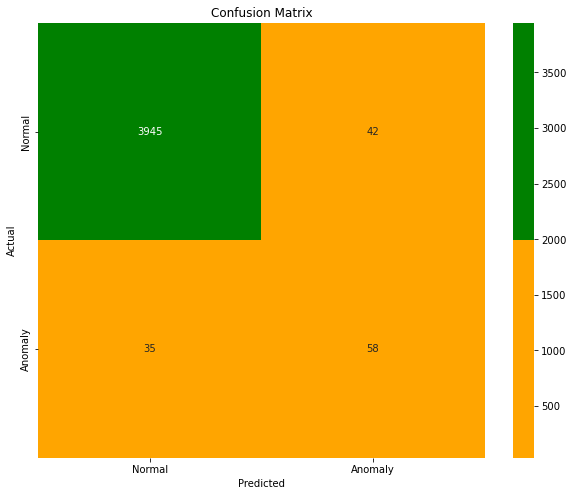

In [36]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

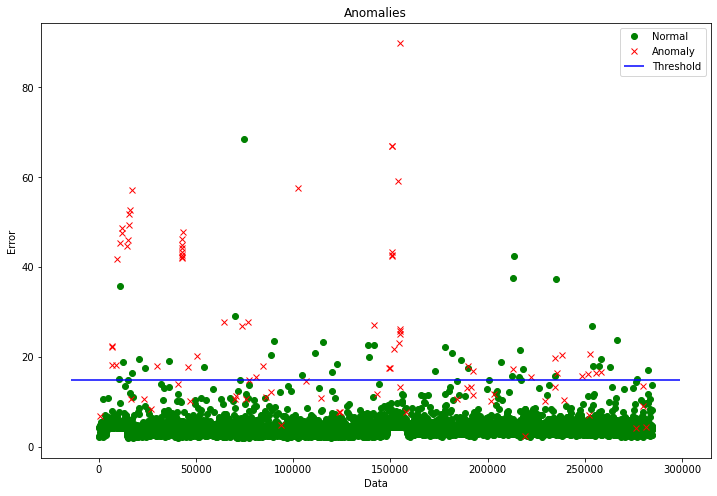

In [37]:
viz.draw_anomaly(y_test, error, threshold)